<a href="https://colab.research.google.com/github/hardscrey/steam_user_clustering/blob/main/steam_user_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Структуризация данных, очистка и кластеризации пользователей (steam_user_clustering)
**Цель проекта:**
- Извелечь данные, очистить, провести разведочный анализ.
- Разбить пользователей на кластеры, и интерпретировать поведение каждого кластера

**Структура ноутбука:**

0. Установка зависимостей и импорты
1. Параметры и загрузка данных
2. Извлечение данных и создание датафрейма
3. Предобработка: очистка, удаление лишних колонок
4. Первичный анализ данных и визуализация
5. Кластеризация пользователей
6. Визуализация кластеров
7. Анализ кластеров
8. Общие выводы по проекту
> Все результаты сохраняются в папках `images/` и `results/`.

# 0) Установка зависимостей и импорты

In [31]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import zipfile
import shutil
import json
import sqlite3
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [32]:
# Настройки отображения
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (8,6)
pd.set_option('display.max_columns', None)

In [33]:
# Создаём папки для артефактов
os.makedirs('images', exist_ok=True)
os.makedirs('results', exist_ok=True)

# 1) Параметры и загрузка данных

In [34]:
# Укажите путь к локальному archive.zip
src_path = '/content/drive/MyDrive/Colab Notebooks/archive.zip'
dst_path = '/content/steam_profiles.zip'

shutil.copy(src_path, dst_path)

'/content/steam_profiles.zip'

In [35]:
# Проведем разархивацию
with zipfile.ZipFile('/content/steam_profiles.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/steam_data')

In [36]:
# Подключение к базе SQLite
db_path = '/content/steam_data/users'
conn = sqlite3.connect(db_path)
cursor = conn.cursor()
# Просмотр таблиц
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('accounts',)]


In [37]:
# Просмотр содержания таблицы
cursor.execute("PRAGMA table_info(accounts);")
for col in cursor.fetchall():
    print(col)

(0, 'steamID', 'INTEGER', 0, None, 1)
(1, 'games_used', 'BOOLEAN', 0, None, 0)
(2, 'friends_available', 'BOOLEAN', 0, None, 0)
(3, 'friends', 'JSONB', 0, None, 0)
(4, 'games', 'JSONB', 0, None, 0)


In [38]:
# Просмотр содержания строки
cursor.execute("SELECT *\
                FROM accounts\
                WHERE games_used = 1\
                LIMIT 1;")
rows = cursor.fetchall()

# 2) Извлечение данных и создание датафрейма

In [39]:
# Извлечем 100 000 аккаунтов
cursor.execute("SELECT steamID, games_used, friends_available, friends, games\
                FROM accounts\
                WHERE games_used = 1\
                AND games IS NOT NULL\
                AND games != '[]'\
                LIMIT 100000\
                ")
rows = cursor.fetchall()

Выбираем активные аккаунты с доступной информацией об играх

In [40]:
# упорядочем данные для формирования датафрейма
processed_data = []

for row in rows:
    steam_id, games_used, friends_available, friends_json, games_json = row

    try:
        friends = json.loads(friends_json) if friends_json else []
        games = json.loads(games_json) if games_json else []
    except Exception:
        continue
    # Подсчитываем число друзей, игр, общее и среднее игровое время, долю рекомендованных игр
    num_friends = len(friends)
    num_games = len(games)

    total_playtime_forever = sum(game.get('playtime_forever', 0) for game in games)
    total_playtime_2weeks = sum(game.get('playtime_2weeks', 0) for game in games)

    avg_playtime = total_playtime_forever / num_games if num_games > 0 else 0
    recommend_rate = (sum(1 for game in games if game.get('is_recommended') == 1) / num_games * 100 if num_games > 0 else 0)

    processed_data.append({
        'steamID': steam_id,
        'games_used': games_used,
        'friends_available': friends_available,
        'num_friends': num_friends,
        'num_games': num_games,
        'total_playtime_forever': total_playtime_forever,
        'total_playtime_2weeks': total_playtime_2weeks,
        'avg_playtime_per_game': avg_playtime,
        'recommend_rate': recommend_rate
    })

In [41]:
df = pd.DataFrame(processed_data)
print('Размер датасета:', df.shape)
df.head(3).to_csv('results/df_example.csv')
display(df.head(3))

Размер датасета: (100000, 9)


,steamID,games_used,friends_available,num_friends,num_games,total_playtime_forever,total_playtime_2weeks,avg_playtime_per_game,recommend_rate
0,76561197960265778,1,0,397,857,1474519,3830,1720.558926,0.583431
1,76561197960265822,1,0,0,352,769307,0,2185.531250,0.568182
2,76561197960265841,1,0,82,386,65461,1613,169.588083,3.886010


Описание фич:

`steamID` - Уникальный ID аккаунта.

`games_used` - количество установленных игр.

`friends_available` - Количество доступных друзей.

`num_friends` - Количество друзей.

`num_games` - количество игр.

`total_playtime_forever`- общее игровое время.

`total_playtime_2weeks`- игровое время за 2 недели.

`avg_playtime_per_game`- среднее игровое время на 1 игру.

`recommend_rate`- процент оцененных игр.


# 3) Предобработка: очистка, удаление лишних колонок

In [42]:
# Краткая проверка
display(df.info())
display(df.describe(include='all').T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   steamID                 100000 non-null  int64  
 1   games_used              100000 non-null  int64  
 2   friends_available       100000 non-null  int64  
 3   num_friends             100000 non-null  int64  
 4   num_games               100000 non-null  int64  
 5   total_playtime_forever  100000 non-null  int64  
 6   total_playtime_2weeks   100000 non-null  int64  
 7   avg_playtime_per_game   100000 non-null  float64
 8   recommend_rate          100000 non-null  float64
dtypes: float64(2), int64(7)
memory usage: 6.9 MB


None

,count,mean,std,min,25%,50%,75%,max
steamID,100000.0,7.656120e+16,2.387991e+07,7.656120e+16,7.656120e+16,7.656120e+16,7.656120e+16,7.656120e+16
games_used,100000.0,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
friends_available,100000.0,8.134600e-01,3.895438e-01,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
num_friends,100000.0,4.298870e+00,3.255129e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.579000e+03
num_games,100000.0,5.510650e+02,1.037907e+03,3.000000e+00,1.680000e+02,3.140000e+02,5.700000e+02,3.720600e+04
total_playtime_forever,100000.0,5.857576e+05,1.313590e+06,0.000000e+00,2.590038e+05,4.694780e+05,7.472240e+05,1.529148e+08
total_playtime_2weeks,100000.0,2.279385e+03,9.740247e+03,0.000000e+00,2.500000e+01,1.089000e+03,2.908000e+03,6.415680e+05
avg_playtime_per_game,100000.0,2.420294e+03,4.848608e+03,0.000000e+00,6.305495e+02,1.423890e+03,2.756945e+03,3.476337e+05
recommend_rate,100000.0,2.619437e+00,3.939457e+00,0.000000e+00,6.024096e-01,1.379310e+00,3.045685e+00,1.000000e+02


In [43]:
# Проверим пропуски
df.isnull().sum()

,0
steamID,0
games_used,0
friends_available,0
num_friends,0
num_games,0
total_playtime_forever,0
total_playtime_2weeks,0
avg_playtime_per_game,0
recommend_rate,0


In [44]:
# Преобразуем минуты в часы
df['total_playtime_forever_hr'] = df['total_playtime_forever'] / 60
df['total_playtime_2weeks_hr'] = df['total_playtime_2weeks'] / 60
df['avg_playtime_per_game_hr'] = df['avg_playtime_per_game'] / 60

In [45]:
#Удаляем не нужные стобцы
df = df.drop(['friends_available', 'total_playtime_forever', 'total_playtime_2weeks', 'avg_playtime_per_game', 'games_used', 'steamID'], axis=1)

# 4) Первичный анализ данных и визуализация

Построим коробчатые диаграммы, чтобы проверить распредеделение данных и выбросы

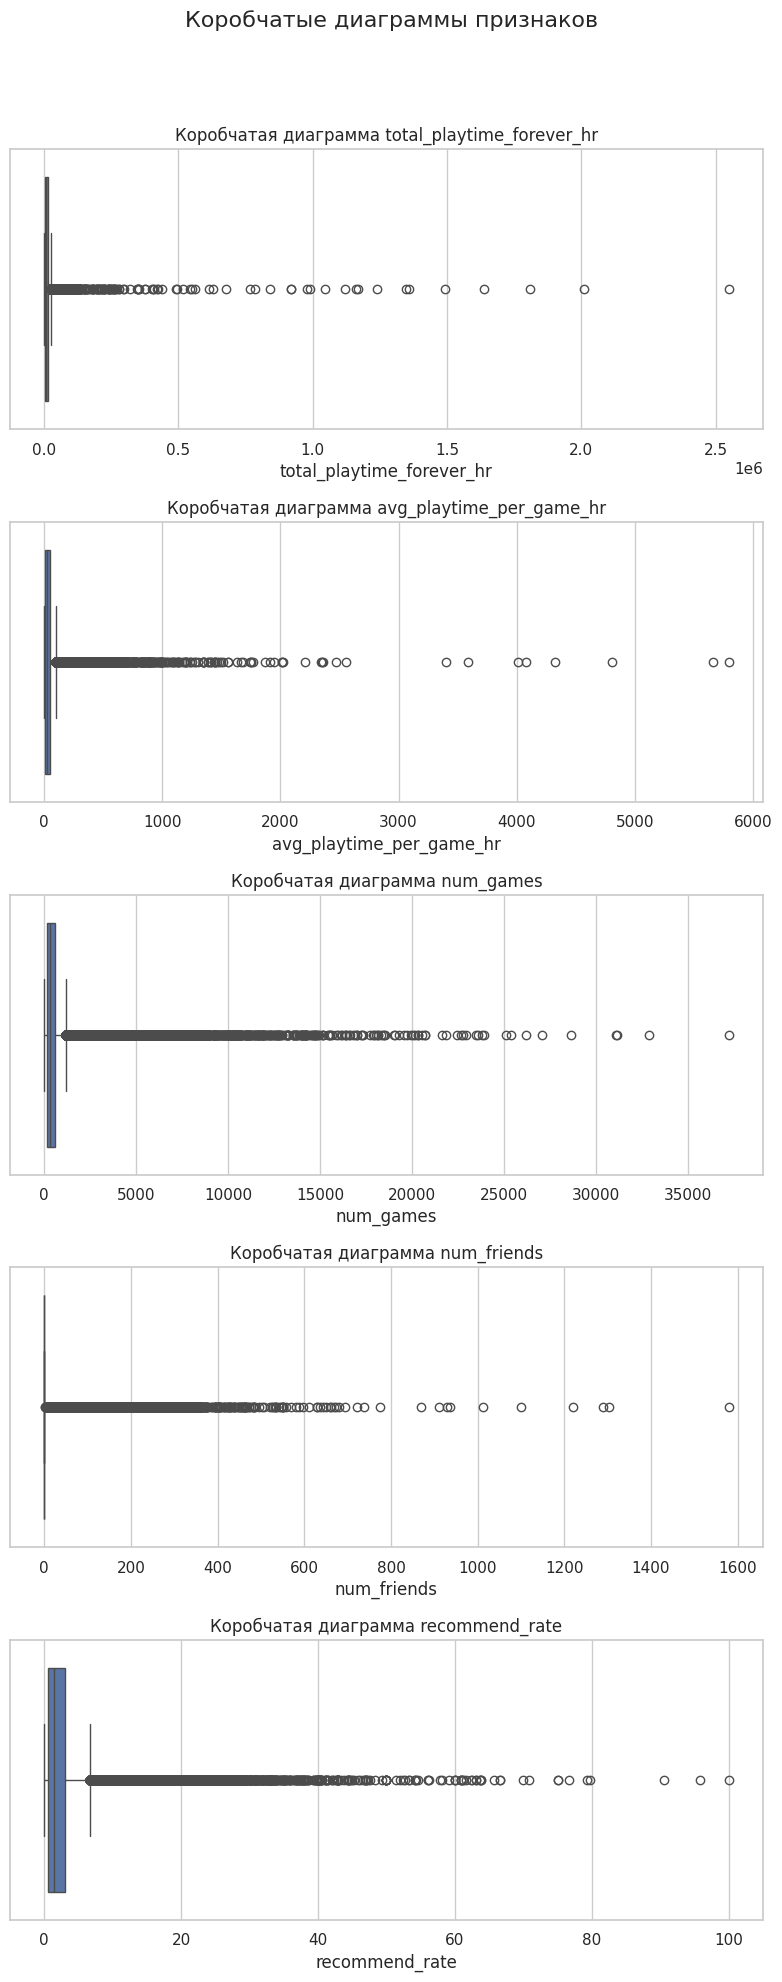

In [46]:
cols = ['total_playtime_forever_hr', 'avg_playtime_per_game_hr', 'num_games', 'num_friends', 'recommend_rate']
fig, axes = plt.subplots(nrows=len(cols), ncols=1, figsize=(8, 4 * len(cols)))
fig.suptitle('Коробчатые диаграммы признаков', y=0.99, fontsize=16)

for i, col in enumerate(cols):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f'Коробчатая диаграмма {col}')
    axes[i].set_xlabel(col)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('images/boxplot_feature_diagrams.png', dpi=200)
plt.show()

В каждом признаке присутствуют выбросы, избавимся от них, взяв 98 квантиль

In [47]:
high = df[['num_games', 'total_playtime_forever_hr', 'total_playtime_2weeks_hr', 'avg_playtime_per_game_hr']].quantile(0.97)
mask = df[['num_games', 'total_playtime_forever_hr', 'total_playtime_2weeks_hr', 'avg_playtime_per_game_hr']] <= high
df_filtered = df[mask.all(axis=1)]

In [48]:
display(df_filtered.describe(include='all').T)

,count,mean,std,min,25%,50%,75%,max
num_friends,90219.0,3.792948,28.913859,0.0,0.000000,0.000000,0.000000,1304.000000
num_games,90219.0,421.658642,373.783940,4.0,171.000000,307.000000,536.000000,2246.000000
recommend_rate,90219.0,2.526177,3.670853,0.0,0.621118,1.379310,2.970297,79.687500
total_playtime_forever_hr,90219.0,8099.228168,5626.399568,0.0,4036.833333,7329.616667,11419.466667,26457.766667
total_playtime_2weeks_hr,90219.0,27.506978,31.989950,0.0,0.133333,16.266667,43.591667,148.600000
avg_playtime_per_game_hr,90219.0,31.246693,29.704419,0.0,10.736704,22.898205,42.327963,164.749432


Оцениваем распределение после усечения выборки

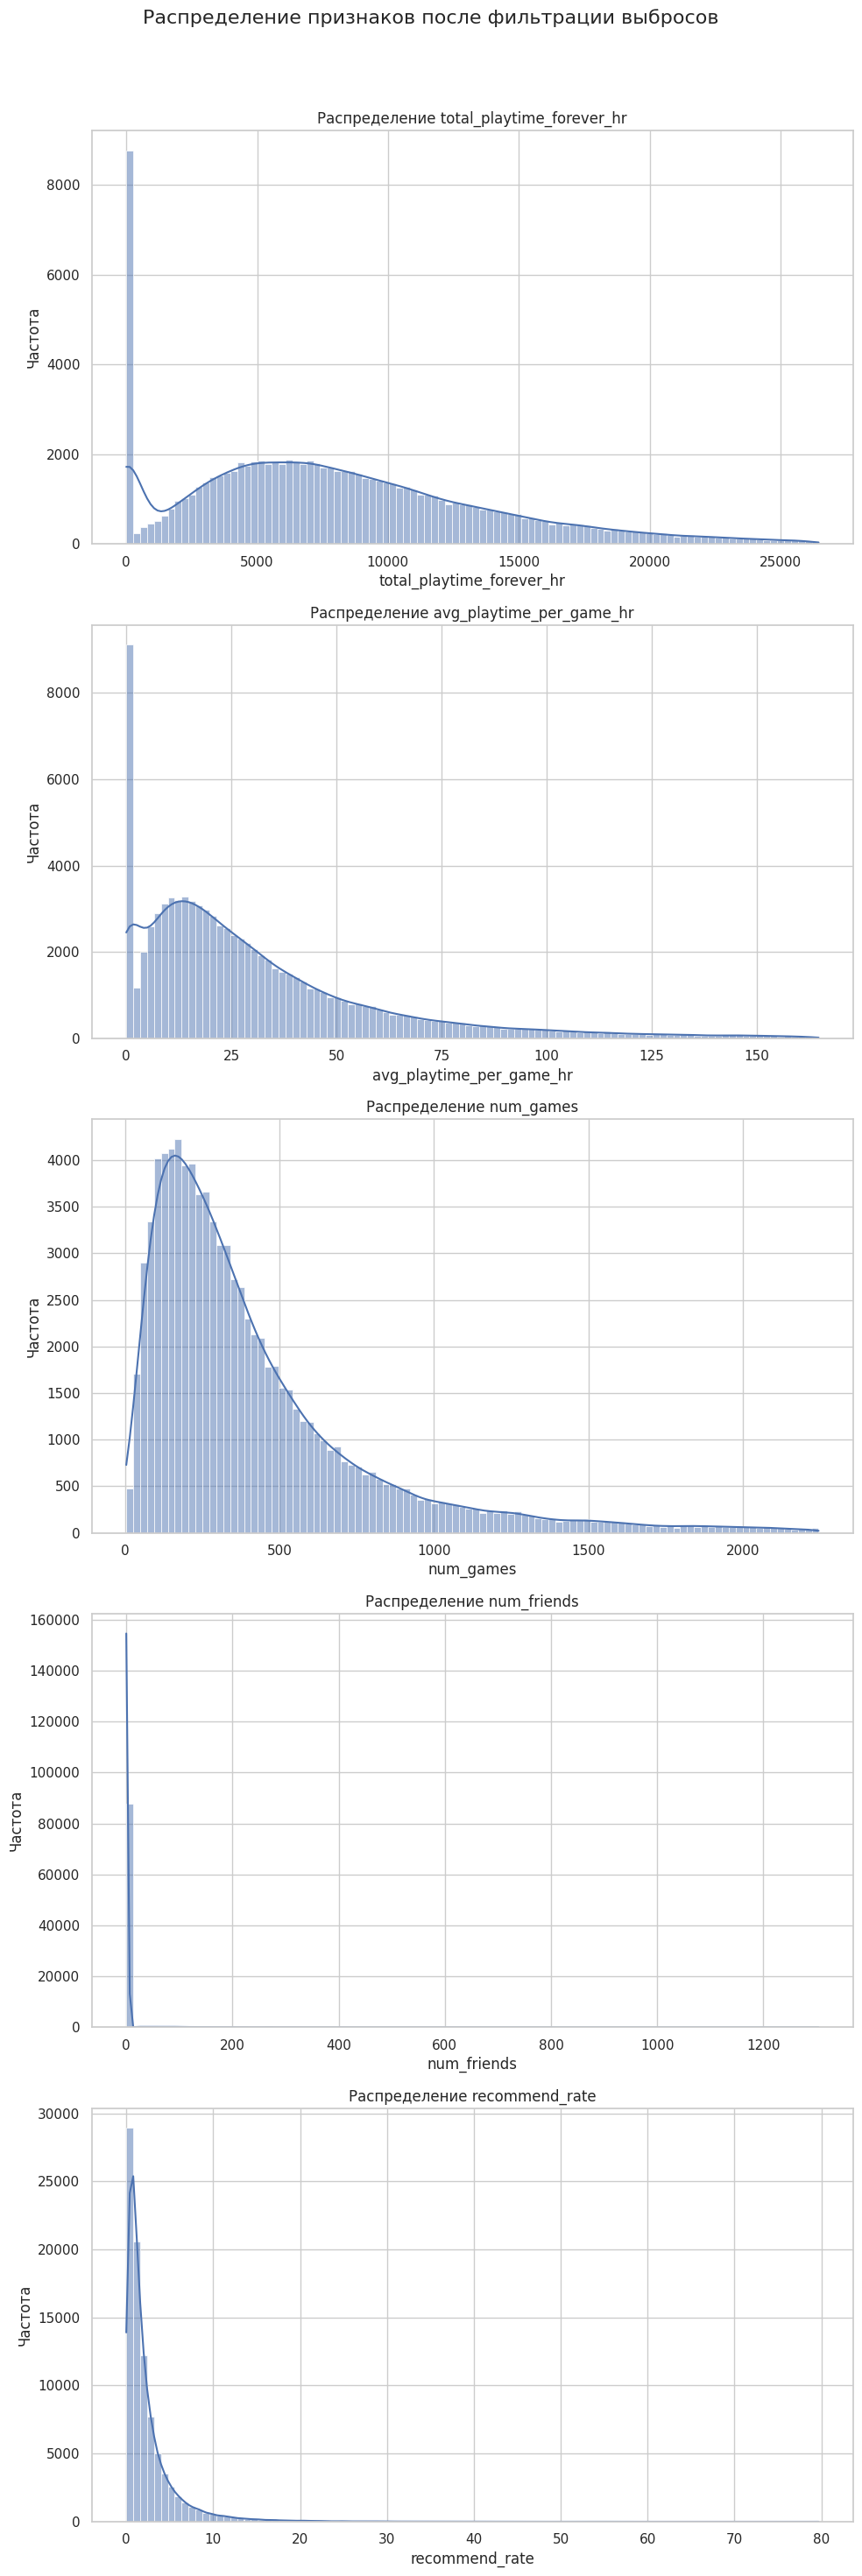

In [49]:
cols = ['total_playtime_forever_hr', 'avg_playtime_per_game_hr', 'num_games', 'num_friends', 'recommend_rate']

fig, axes = plt.subplots(nrows=len(cols), ncols=1, figsize=(10, 6 * len(cols)))
fig.suptitle('Распределение признаков после фильтрации выбросов', y=0.98, fontsize=16)

for i, col in enumerate(cols):
    sns.histplot(df_filtered[col], bins=100, kde=True, ax=axes[i])
    axes[i].set_title(f'Распределение {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Частота')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('images/histplot_feature_distribution_diagrams.png', dpi=200)
plt.show()

# 5) Кластеризация пользователей

In [50]:
# Масштабируем
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_filtered)

Определим оптимальное количество кластеров (по методу локтя)

In [51]:
inertia = []
for k in range(1, 10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

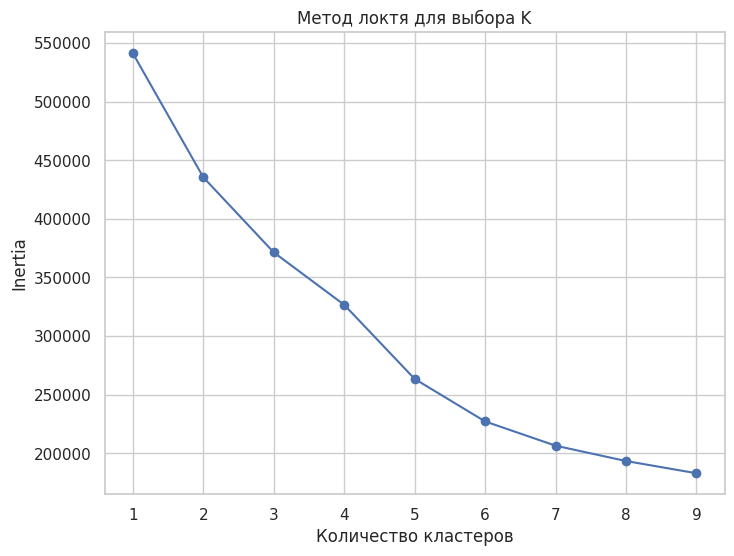

In [52]:
plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel("Количество кластеров")
plt.ylabel("Inertia")
plt.title("Метод локтя для выбора K")
plt.savefig('images/kmeans_clustering.png', dpi=200)
plt.show()

Судя по графику оптимальныым количеством будет 5 кластеров, однако для уверенности построим дендрограмму на подвыборке:

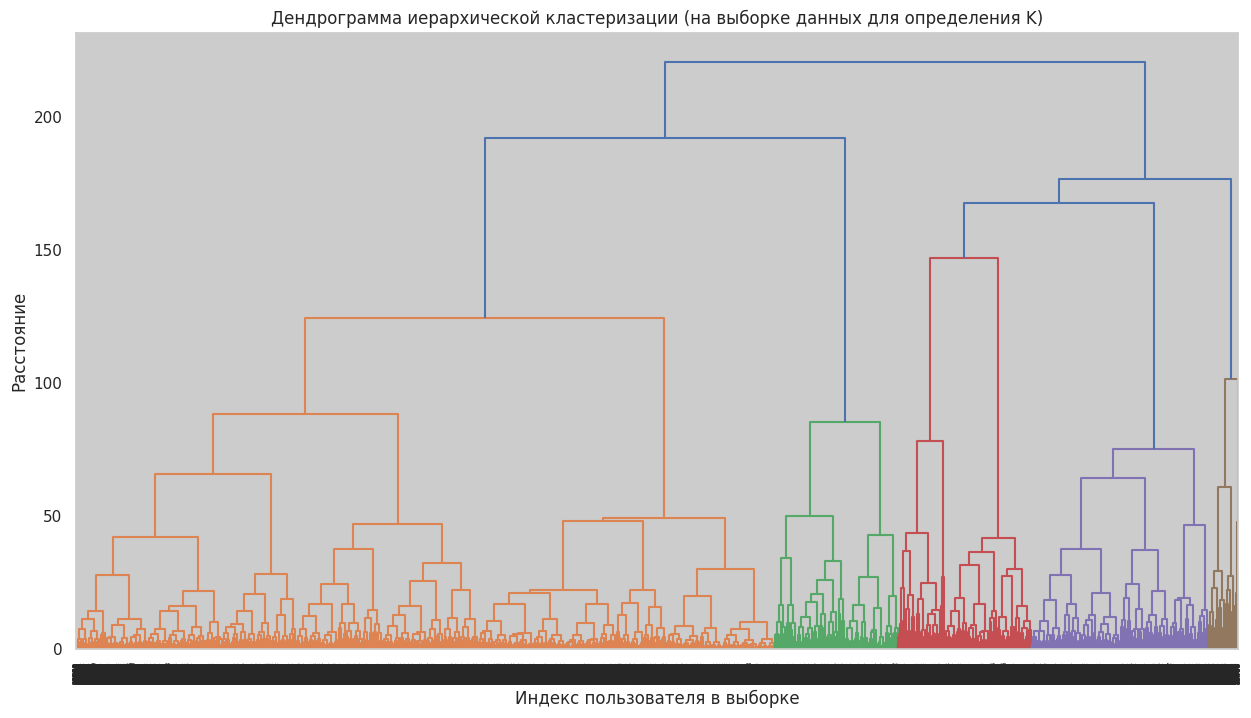

In [53]:
sample_size = 27500  # Можно настроить размер выборки
np.random.seed(42)

# Генерируем случайные индексы для выборки
sample_indices = np.random.choice(X_scaled.shape[0], sample_size, replace=False)
X_scaled_sample = X_scaled[sample_indices]
# Создаем DataFrame для выборки для определения k
df_clust_sample_for_k_determination = df_filtered.iloc[sample_indices].copy()

# Выполним иерархическую кластеризацию с методом Ward на выборке данных
linked_sample = linkage(X_scaled_sample, method='ward')

# Построим дендрограмму на выборке данных для определения числа кластеров
plt.figure(figsize=(15, 8))
dendrogram(linked_sample,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Дендрограмма иерархической кластеризации (на выборке данных для определения K)')
plt.xlabel('Индекс пользователя в выборке')
plt.ylabel('Расстояние')
plt.savefig('images/dendrogram_sample_for_k.png', dpi=200)
plt.show()

Дендограмма подтверждает показания kmeans, а значит 5 кластеров это оптимальные вариант

# 6) Визуализация кластеров

In [54]:
df_clust = df_filtered
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

df_clust["cluster"] = clusters
df_clust["kmeans_cluster"] = clusters # Добавляем столбец с кластерами для дальнейшего анализа и визуализации

Визуализация кластеров

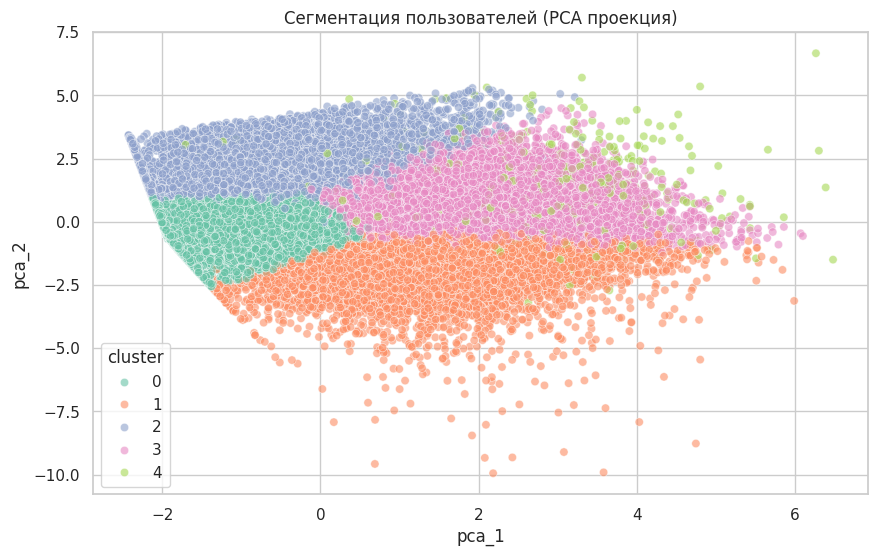

In [55]:
# PCA для визуализации
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

df_clust["pca_1"] = components[:, 0]
df_clust["pca_2"] = components[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clust, x="pca_1", y="pca_2", hue="cluster", palette="Set2", alpha=0.6)
plt.title("Сегментация пользователей (PCA проекция)")
plt.savefig('images/pca_user_segmentation.png', dpi=200)
plt.show()

Расчет коэффициента силуэта, для проверки количества кластеров

In [56]:
df_clust['kmeans_cluster'] = kmeans.fit_predict(X_scaled)

In [57]:
from sklearn.metrics import silhouette_score
silhouette_score(X_scaled, kmeans.labels_)

np.float64(0.30481158714242695)

# 7) Анализ кластеров

Определим количество пользователей в каждом кластере

In [ ]:
cluster_proportions = df_clust['kmeans_cluster'].value_counts(normalize=True) * 100

plt.figure(figsize=(8, 8))
plt.pie(cluster_proportions, labels=cluster_proportions.index, autopct='%1.1f%%', startangle=140, pctdistance=0.85)
plt.title('Процентное соотношение пользователей в каждом кластере')
plt.axis('equal')
plt.tight_layout()
plt.savefig('images/pieplot_clusters.png', dpi=200)
plt.show()

Агрегация и анализ средних значений по каждому кластеру

In [ ]:
df_clusters = df_clust.groupby('kmeans_cluster')[['num_friends', 'num_games', 'recommend_rate','total_playtime_forever_hr', 'avg_playtime_per_game_hr']].mean()
df_clusters.to_csv('results/df_clusters.csv')
display(df_clusters)

Построение столбчатых и коробчатых диаграмм для каждого параметра

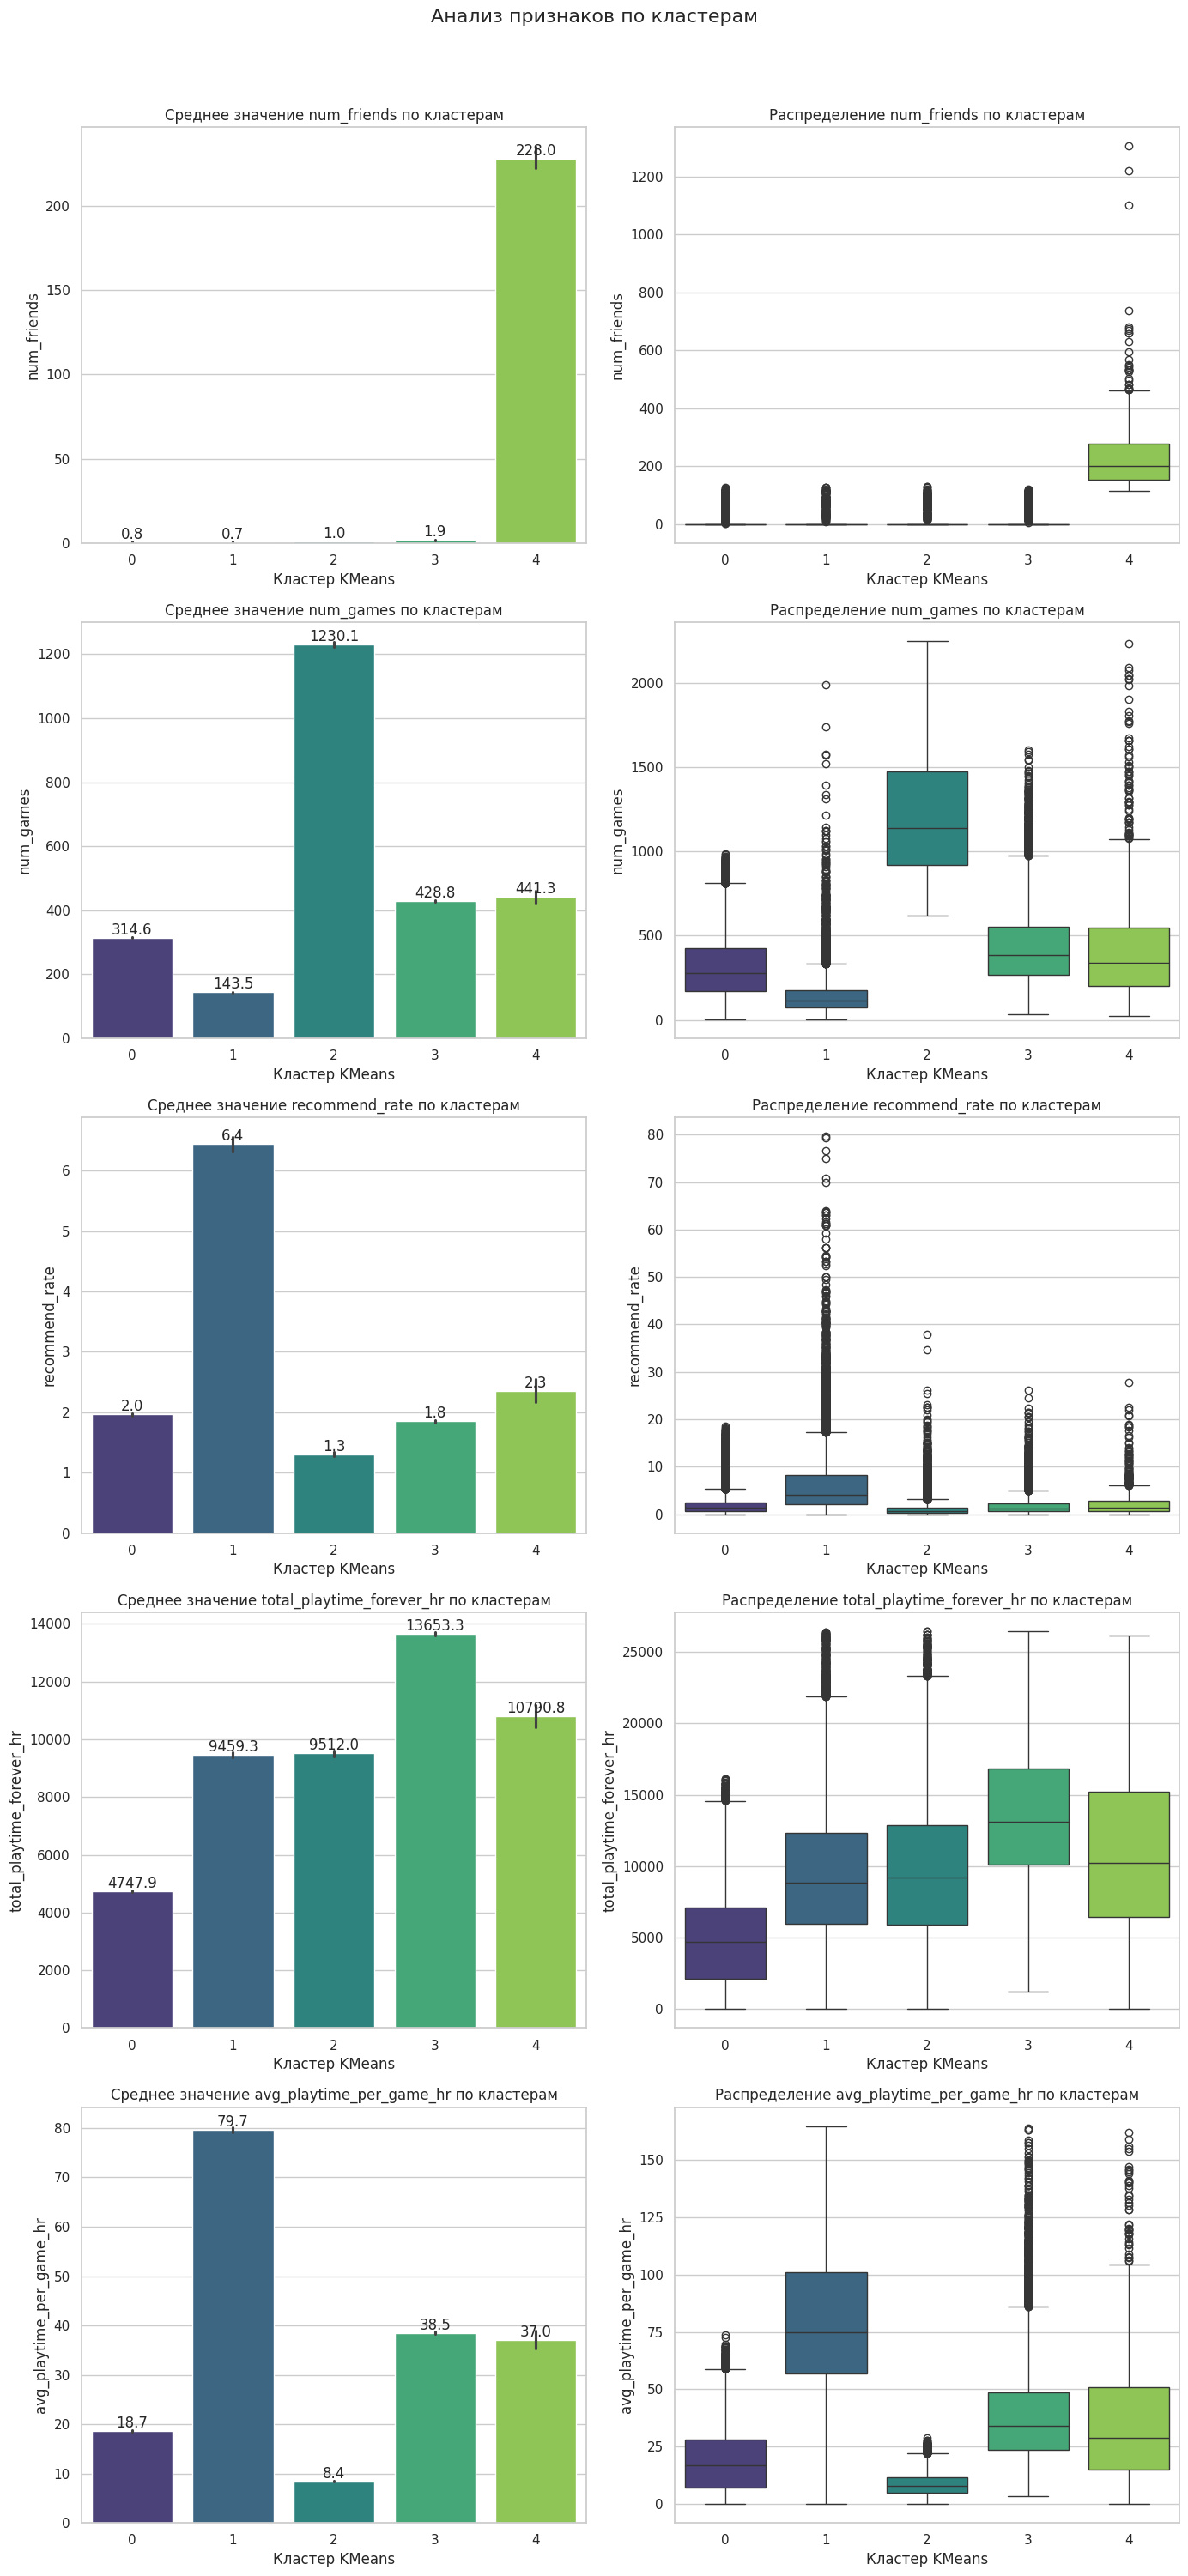

In [60]:
features = ['num_friends', 'num_games', 'recommend_rate', 'total_playtime_forever_hr', 'avg_playtime_per_game_hr']

fig, axes = plt.subplots(nrows=len(features), ncols=2, figsize=(14, 6 * len(features)))
fig.suptitle('Анализ признаков по кластерам', fontsize=16, y=1.0)

for i, col in enumerate(features):
    sns.barplot(x='kmeans_cluster', y=col, data=df_clust, ax=axes[i, 0], palette='viridis')
    axes[i, 0].set_title(f'Среднее значение {col} по кластерам')
    axes[i, 0].set_xlabel('Кластер KMeans')
    axes[i, 0].set_ylabel(col)
    for container in axes[i, 0].containers:
        axes[i, 0].bar_label(container, fmt='%.1f')

    sns.boxplot(x='kmeans_cluster', y=col, data=df_clust, ax=axes[i, 1], palette='viridis')
    axes[i, 1].set_title(f'Распределение {col} по кластерам')
    axes[i, 1].set_xlabel('Кластер KMeans')
    axes[i, 1].set_ylabel(col)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig('images/boxplots_barplots_of_features.png', dpi=200)
plt.show()

# 8) Общие выводы по проекту

1. **Обработка данных:**
   - Данные были успешно извлечены из базы SQLite, отобраны 100 000 активных аккаунтов с информацией об играх.
   - Создан DataFrame с показателями активности пользователей: количество друзей, количество игр, общее игровое время, игровое время за 2 недели, среднее игровое время на игру и процент рекомендованных игр.
   - Все временные показатели конвертированы из минут в часы для удобства анализа.
   - Проведен EDA, в ходе которого были выявлены значительные выбросы в данных. Для их обработки были применены квантили (97-й перцентиль), что позволило получить более репрезентативное распределение для кластеризации.

2. **Разбиение пользователей на кластеры и интерпретация:**

   - Для сегментации пользователей был применен метод кластеризации K-Means.
   - Оптимальное количество кластеров, определенное с помощью метода локтя и подтвержденное анализом дендрограммы на выборке данных, составило 5.
   - Получен коэффициент силуэта около 0.3, что указывает на разумную, хотя и не идеально четкую, кластеризацию.
   - Визуализация кластеров с помощью PCA показала наличие различимых групп.

**Описание кластеров:**

 1. Кластер 0 (49.7% пользователей) - Стандартные пользователи, казуалы.

     - Самая многочисленная группа. Характеризуется средним количеством игр (315) и общим игровым временем (3522 ч), малым количеством друзей (0.76) и низким процентом рекомендаций (2.0%).
     
     - Это большинство пользователей, которые играют умеренно и не проявляют высокой социальной активности или активности в рецензировании.

 2. Кластер 1 (14.7% пользователей) - Преданные любимым играм и увлеченные геймеры.

     - Мало друзей (0.69) и относительно небольшое количество игр (143), но самый высокий процент рекомендованных игр (~6.4%) и среднее игровое время (1629 ч).
     
     - Эти пользователи, возможно, более избирательны в выборе игр, но очень активны в оценке и рекомендации игр.

 3. Кластер 2 (11.4% пользователей) - Коллекционеры игр.

     - Небольшое количество друзей (1.0), но очень большое количество игр (1230). Общее игровое время высокое (12903 ч), но процент рекомендаций низкий (1.3%).

     - Это пользователи, которые, возможно, покупают много игр, но не всегда глубоко в них погружаются или неактивны в сообществе, делясь отзывами.

 4. Кластер 3 (22.9% пользователей) - Старые активные игроки.

     - Мало друзей (1.8), среднее количество игр (429) и среднее игровое время (4226 ч). Процент рекомендаций также низкий (1.8%), при этом - самый высокий показатель времени в игре.
     
     - Эта группа более активна, чем кластер 0, но все еще не является хардкорными игроками или активными рекомендателями, скорее всего это пользователи которые играют не часто и не много, однако их акккаунты существуют давно.

 5. Кластер 4 (1.2% пользователей) - Социальные игроки/Продавцы игр, предметов.

     - Наименьшая, но наиболее выраженная группа. Очень много друзей (~228), высокое общее игровое время (11718 ч), и самое высокое среднее время игры на одну игру (27.3 ч). Процент рекомендаций выше среднего (2.3%).

     - Это высоко вовлеченные, социальные игроки, которые проводят много времени в играх и взаимодействуют с сообществом. Или же это продавцы игр/игровых предметов и общие аккаунты.

- Полученная кластеризация может использоваться как основа для построения персонализированных рекомендаций игр, оптимизации маркетинговых стратегий или анализа поведения групп пользователей.

> Полный отчёт, таблицы и графики находятся в папке `results/` и `images/`.